# Data Exploration - Oticon Audio Explorers

In [1]:
from pathlib2 import Path

from collections import Counter

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [2]:
# set seed
np.random.seed(42)

# plot style
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

### Load data

In [3]:
DATA_DIR = Path('../data')

# Load npy-files
Xtrainval   = np.load(DATA_DIR / 'raw/npy/training.npy')
ttrainval      = np.load(DATA_DIR / 'raw/npy/training_labels.npy')
Xtest       = np.load(DATA_DIR / 'raw/npy/test.npy')

# Load matlab files
Xtrain_mat  = loadmat(DATA_DIR / 'raw/mat/training.mat', squeeze_me=True)
ttrain_mat  = loadmat(DATA_DIR / 'raw/mat/training_labels.mat', squeeze_me=True)
Xtest_mat   = loadmat(DATA_DIR / 'raw/mat/test.mat', squeeze_me=True)

# Ensure no data difference
assert np.all(Xtrain_mat['data'] == Xtrainval)
assert np.all(ttrain_mat['data'] == ttrainval)
assert np.all(Xtest_mat['data'] == Xtest)

# Clean up
del Xtrain_mat
del ttrain_mat
del Xtest_mat

#### Split dataset

In [164]:
np.random.seed(0)

# Get indexes
train_idxs  = np.random.choice(np.arange(Xtrainval.__len__()), size=int(Xtrainval.__len__() * 0.8), replace=False)
val_idxs    = np.setdiff1d(np.arange(Xtrainval.__len__()), train_idxs)

assert Xtrainval.__len__() == train_idxs.__len__() + val_idxs.__len__()

# Split training set
Xtrain_orig, Xval_orig = Xtrainval[train_idxs, :, :], Xtrainval[val_idxs, :, :]
ttrain, tval = ttrainval[train_idxs], ttrainval[val_idxs]

In [167]:
print(f"Xtrain: {Xtrain_orig.shape}")
print(f"ttrain: {ttrain.shape}")

print(f"\nXval: {Xval_orig.shape}")
print(f"tval: {tval.shape}")

print(f"\nXtest: {Xtest.shape}")

print(f"\nttrain labels in --> {np.unique(ttrain)}")

print(f"\nXtrain (min, max): {Xtrain.min(), Xtrain.max()}")
print(f"Xtest (min, max): {Xtest.min(), Xtest.max()}")

Xtrain: (42312, 32, 96)
ttrain: (42312,)

Xval: (10578, 32, 96)
tval: (10578,)

Xtest: (5347, 32, 96)

ttrain labels in --> [0 1 2 3 4]

Xtrain (min, max): (-12.516366, 16.262203)
Xtest (min, max): (-80.0, 7.6293945e-06)


### Summary

In [169]:
N_train     = len(Xtrain_orig)
N_val       = len(Xval_orig)
N_test      = len(Xtest)
num_classes = len(np.unique(ttrain))

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
label2idx   = {v: k for k, v in idx2label.items()}

### ChatGPT background
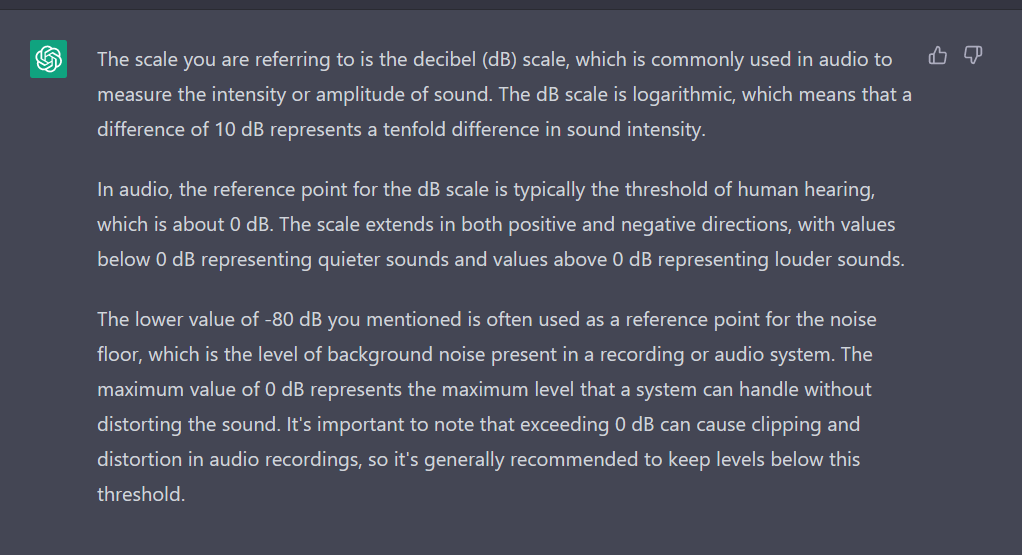

### Visualize label distribution


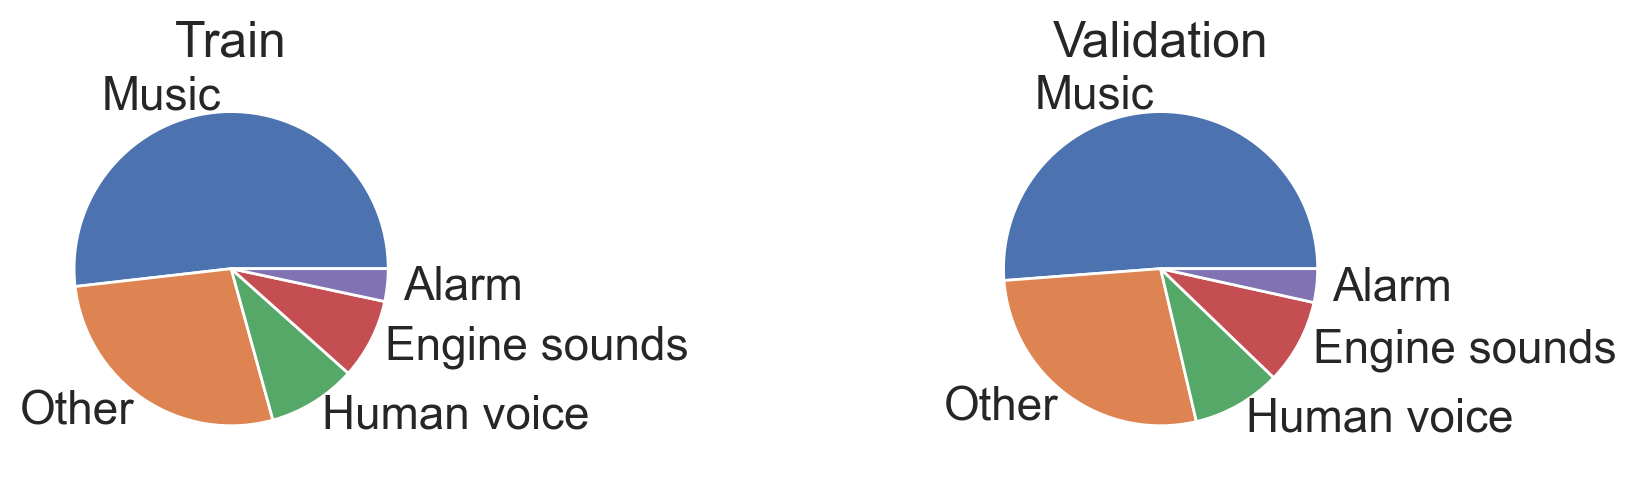

In [7]:
def visualize_label_distribution(ttrain, tval, N_train, N_val):
    label_dist = {'train': dict(sorted(Counter(ttrain).items(), key=lambda x: -x[1])), 'val': dict(sorted(Counter(tval).items(), key=lambda x: -x[1]))}

    label_counts = {dtype: {idx2label[k]: v for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}
    label_freqs = {dtype: {idx2label[k]: v / (N_train if dtype == 'train' else N_val) for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}

    # Plot pie chart
    fig = plt.figure(figsize=(10, 5), dpi=200)
    ax1 = plt.subplot2grid((2,2),(0,0))
    plt.pie(x=label_counts['train'].values(), labels=label_counts['train'].keys())
    plt.title('Train')

    ax1 = plt.subplot2grid((2,2), (0, 1))
    plt.pie(x=label_counts['val'].values(), labels=label_counts['val'].keys())
    plt.title('Validation')

    plt.tight_layout()
    plt.show()

    return label_counts, label_freqs

label_counts, label_freqs = visualize_label_distribution(ttrain, tval, N_train, N_val)


### Data balancing


In [170]:
np.random.seed(0)

# Naive downsampling to minority class size
target_size = min(label_counts['train'].values())

Xtrain_downsampled, ttrain_downsampled = [], []
for i in range(num_classes):
    Xtrain_class    = Xtrain_orig[ttrain == i]
    ttrain_class    = ttrain[ttrain == i]
    N_class         = Xtrain_class.__len__()
    
    # Randomly draw as many points as in minority class 
    keep_idxs   = np.random.choice(np.arange(N_class), size=target_size, replace=False)
    
    # Downsampled class data
    Xtrain_     = Xtrain_class[keep_idxs, :]
    ttrain_     = ttrain_class[keep_idxs]

    # Append class-selected data points
    Xtrain_downsampled.append(Xtrain_)
    ttrain_downsampled.append(ttrain_)

# Concatenate
Xtrain_downsampled = np.vstack(Xtrain_downsampled)
ttrain_downsampled = np.concatenate(ttrain_downsampled)

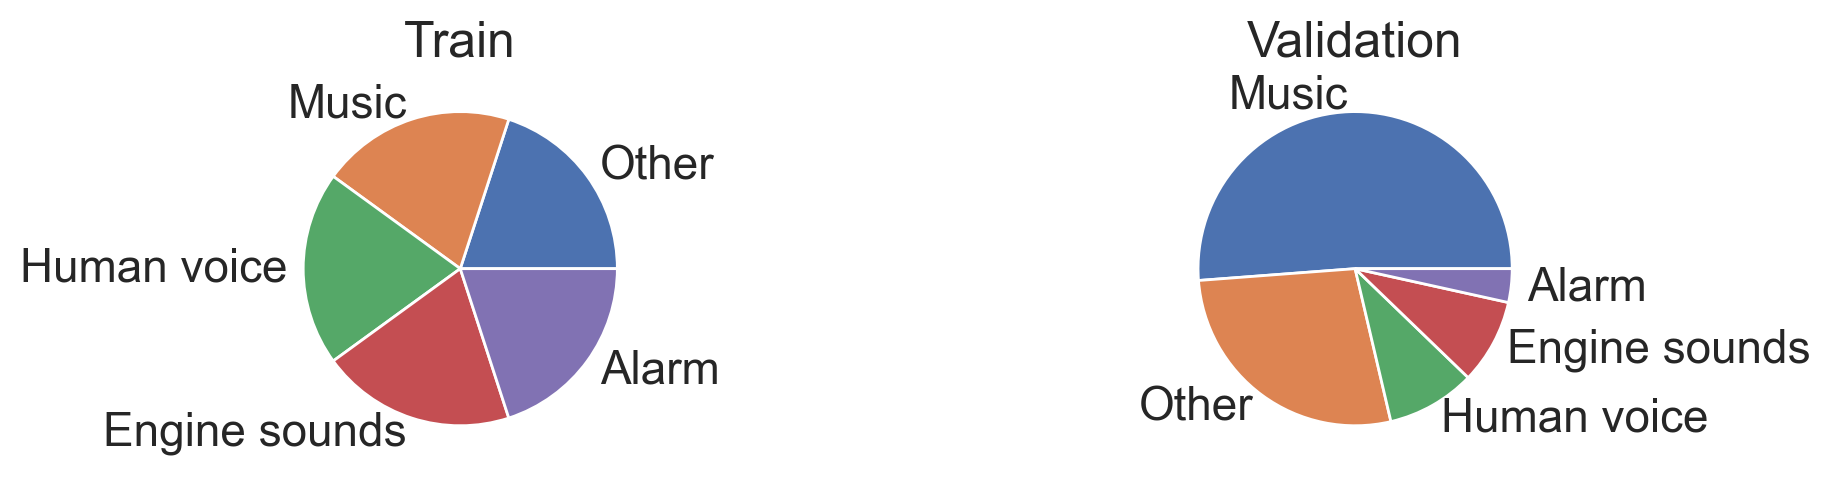

In [171]:
temp, _ = visualize_label_distribution(ttrain_downsampled, tval, len(ttrain_downsampled), N_val)

### Visualize `Xtrain` and `Xtest`

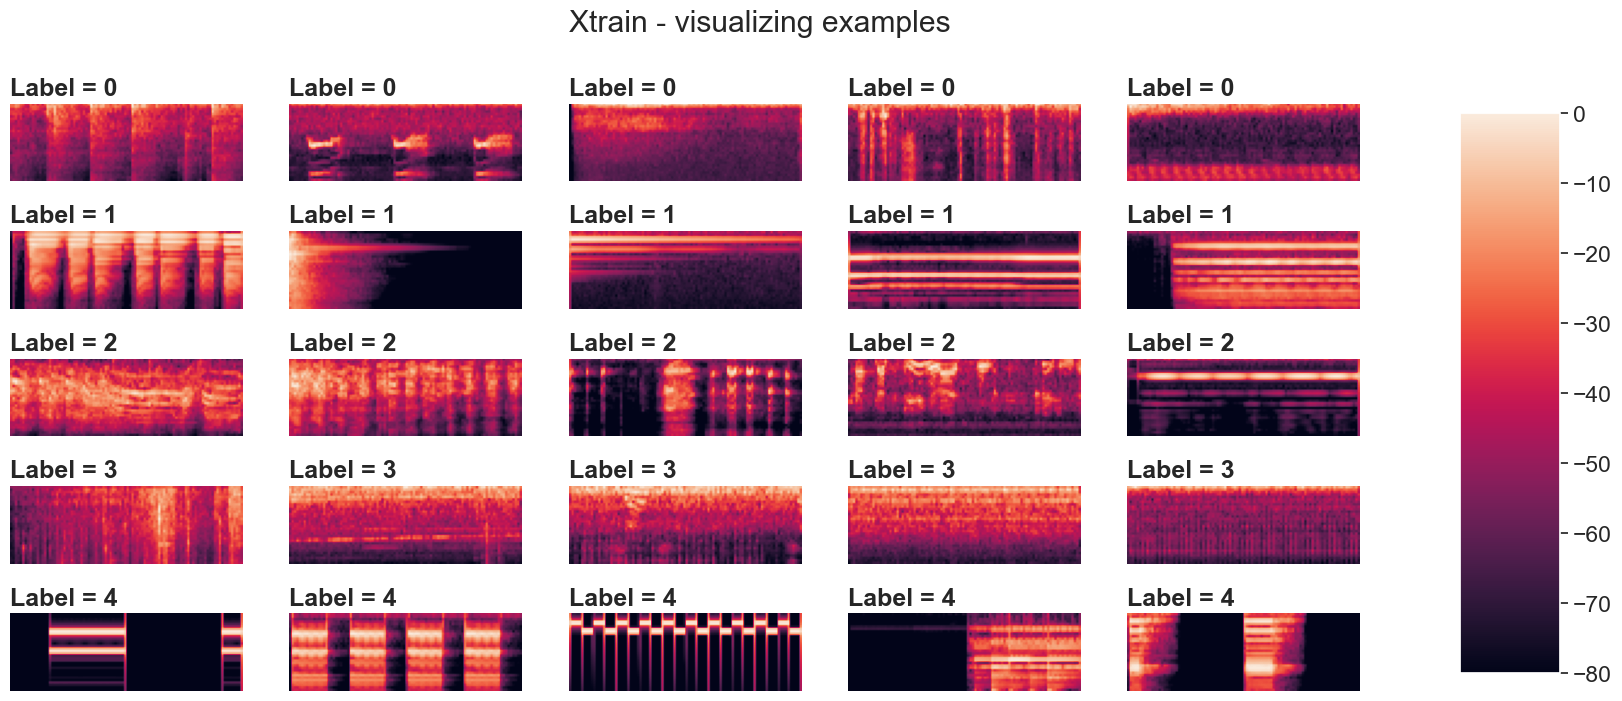

In [11]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xtrain_class = Xtrain_orig[ttrain == i]
        ttrain_class = ttrain[ttrain == i]
        # Select data point
        idx = np.random.choice(len(Xtrain_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xtrain_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {ttrain_class[idx]}", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtrain - visualizing examples')
plt.show()

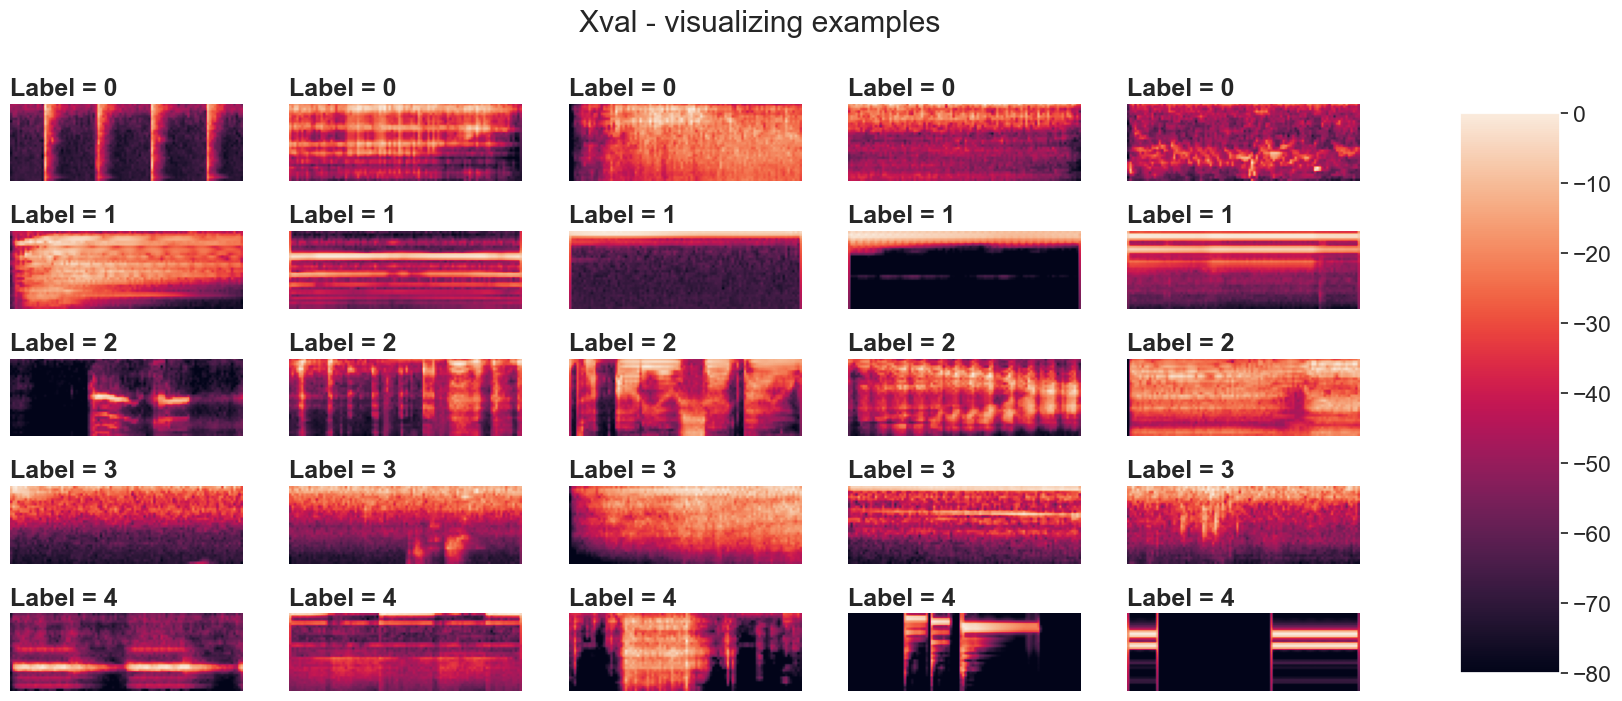

In [172]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xval_class = Xval_orig[tval == i]
        tval_class = tval[tval == i]
        # Select data point
        idx = np.random.choice(len(Xval_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xval_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {tval_class[idx]}", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xval - visualizing examples')
plt.show()

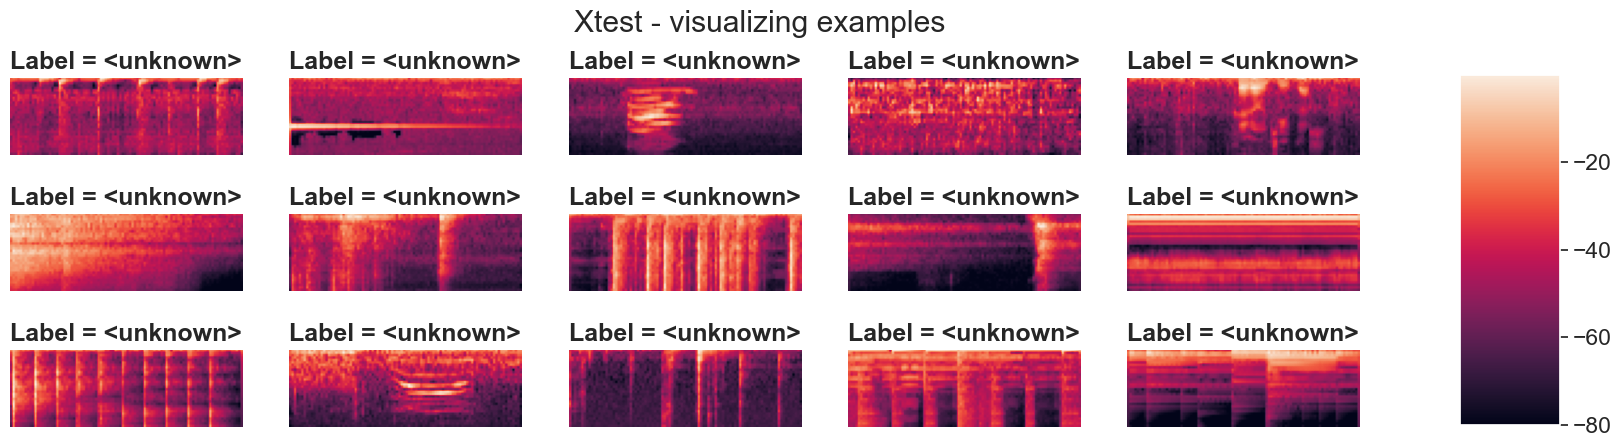

In [12]:
nrows, ncols = 3, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 5), squeeze=False)
for i in range(nrows):
    for j in range(ncols):

        # Select data point
        idx = np.random.choice(len(Xtest))
        # Show spectrogram
        im = axs[i, j].imshow(Xtest[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = <unknown>", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtest - visualizing examples')
plt.show()

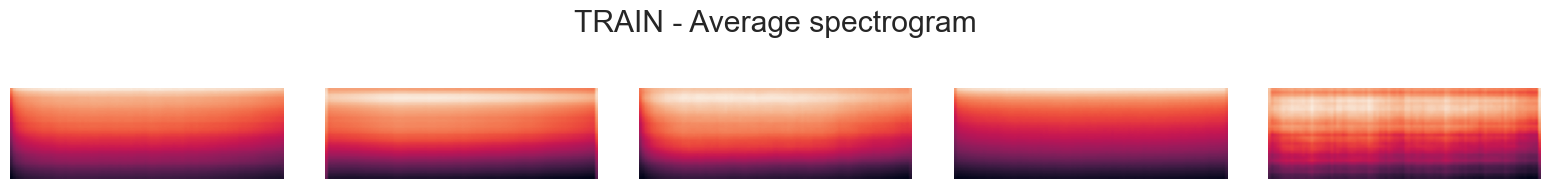

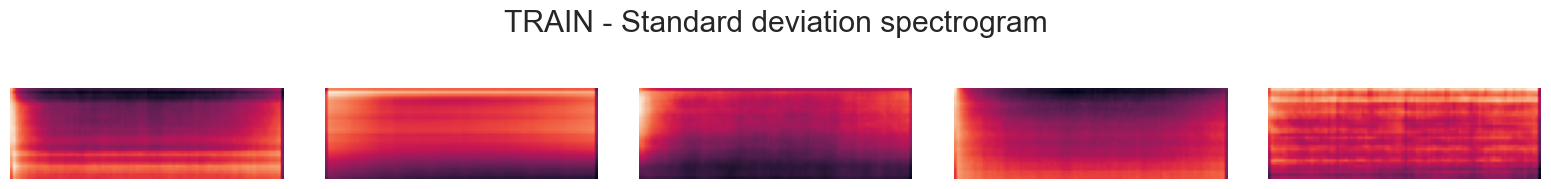

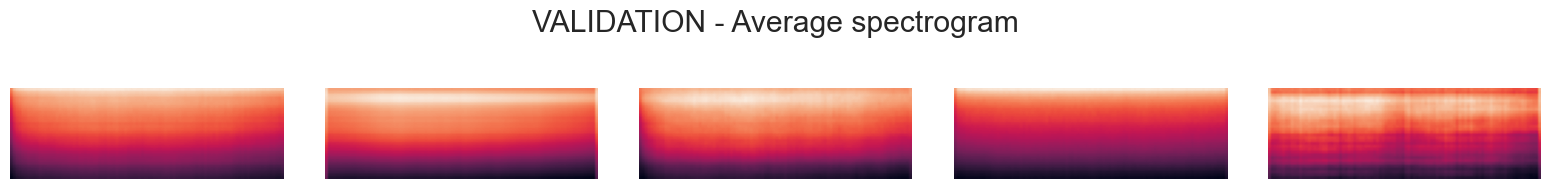

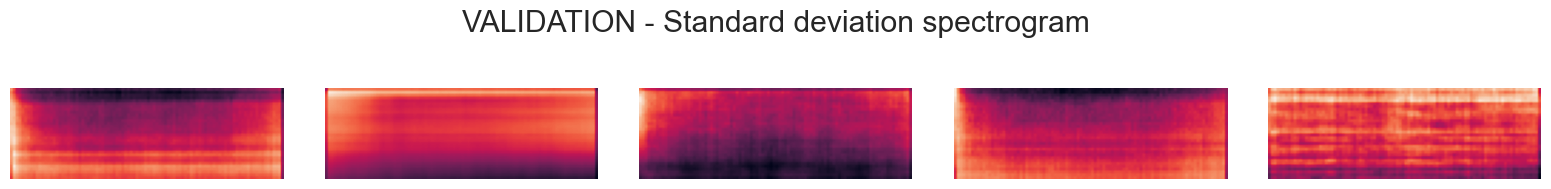

In [173]:
for dtype, X, t in [('train', Xtrain_orig, ttrain), ('validation', Xval_orig, tval)]:

    avg_spectrogram = [X[t == i].mean(axis=0) for i in range(num_classes)]
    std_spectrogram = [X[t == i].std(axis=0) for i in range(num_classes)]

    fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
    for i in range(num_classes): 
        axs[i].imshow(avg_spectrogram[i])
        axs[i].axis('off')

    fig.suptitle(f'{dtype.upper()} - Average spectrogram')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
    for i in range(num_classes): 
        axs[i].imshow(std_spectrogram[i])
        axs[i].axis('off')

    fig.suptitle(f'{dtype.upper()} - Standard deviation spectrogram')
    plt.tight_layout()
    plt.show()

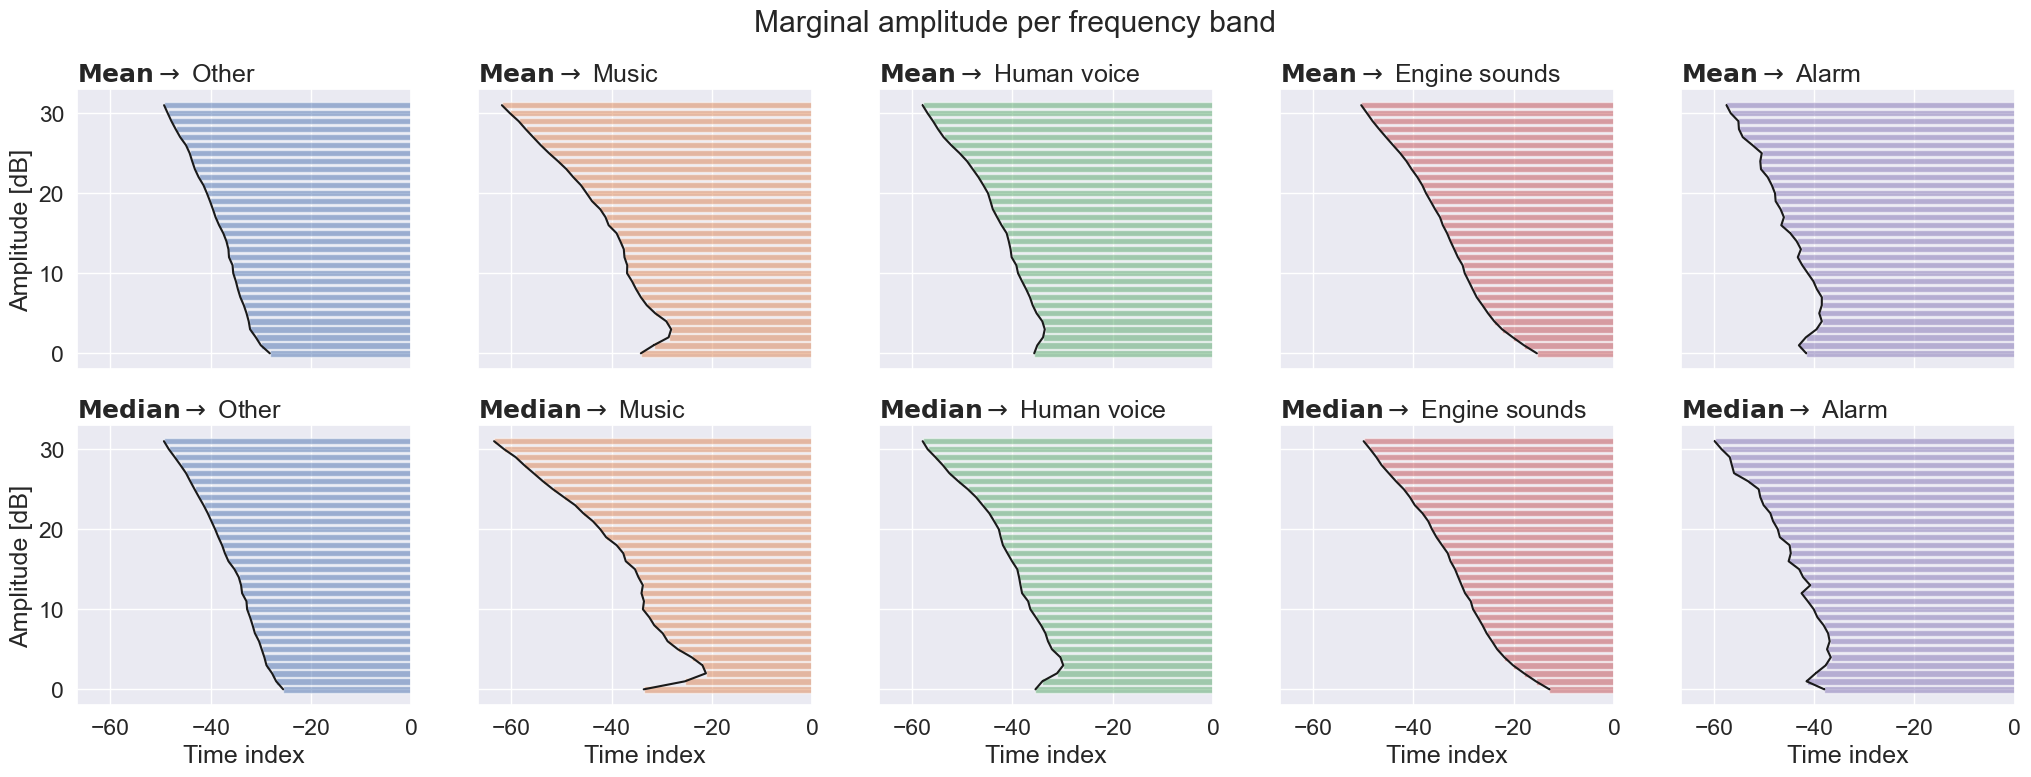

In [174]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

for i in range(num_classes):
    # Stack all spectrograms into 1
    Xtrain_class_h = np.hstack(Xtrain_orig[ttrain == i])

    # Plot marginal mean frequency per frequency band
    axs[0, i].barh(np.arange(32), np.mean(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
    axs[0, i].errorbar(np.mean(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
    axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    # Plot marginal median frequency per frequency band
    axs[1, i].barh(np.arange(32), np.median(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
    axs[1, i].errorbar(np.median(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
    axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    axs[1, i].set_xlabel('Time index')

axs[0, 0].set_ylabel('Amplitude [dB]')
axs[1, 0].set_ylabel('Amplitude [dB]')

fig.suptitle("Marginal amplitude per frequency band")
plt.show()

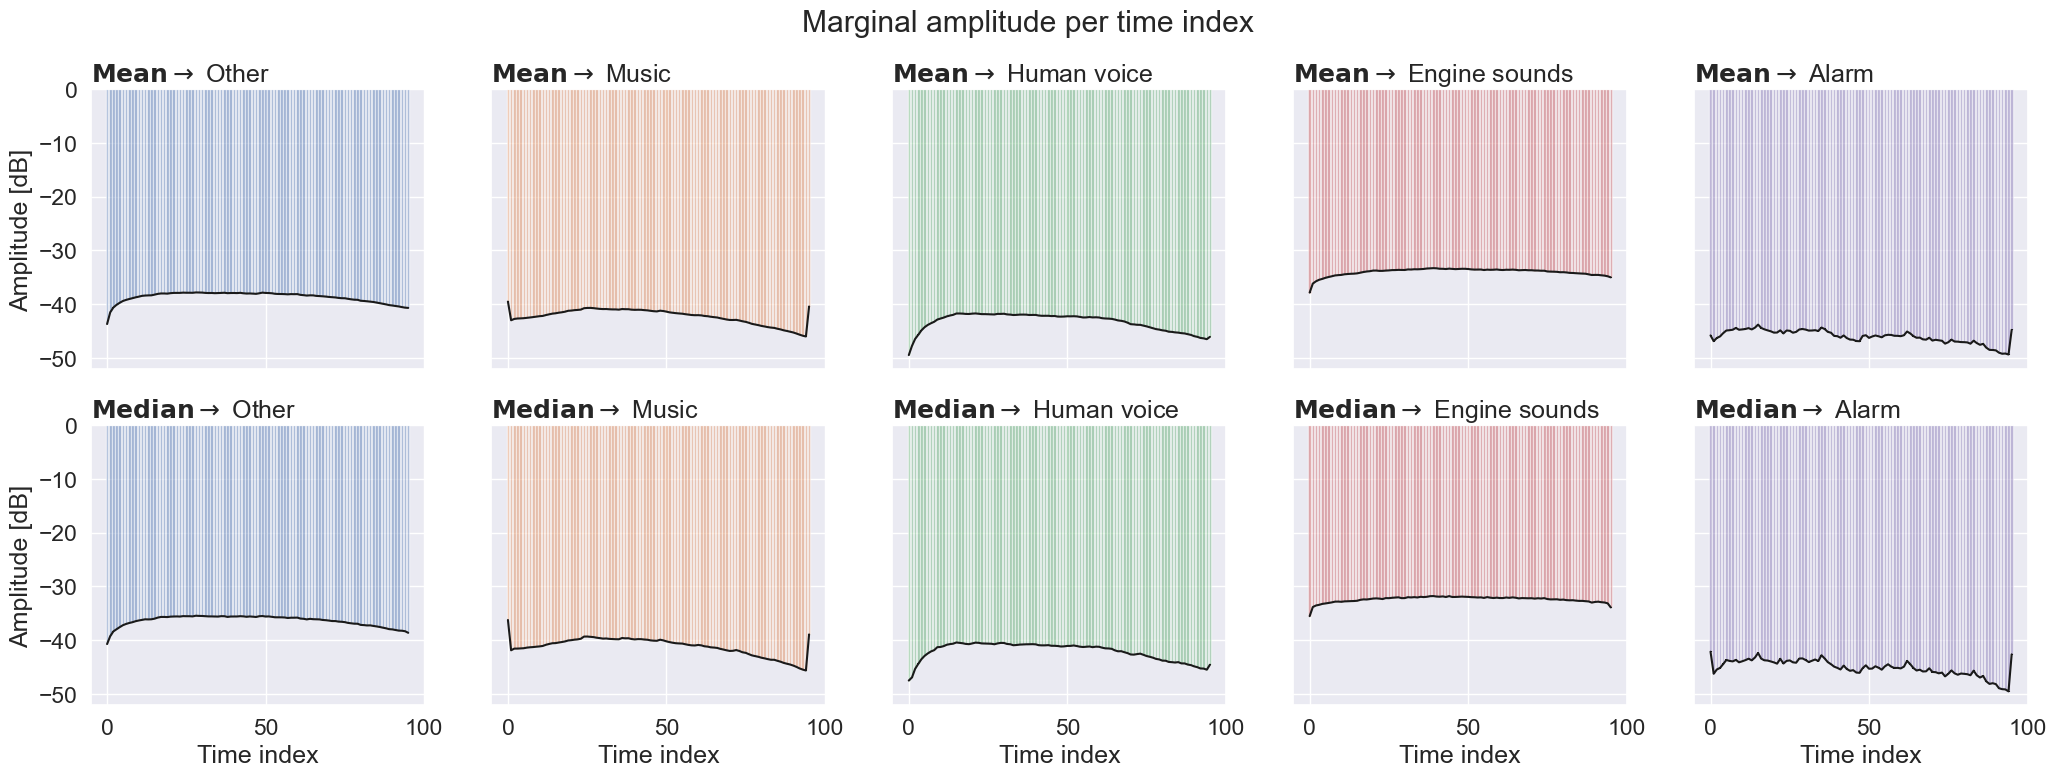

In [16]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

for i in range(num_classes):
    # Stack all spectrograms into 1
    Xtrain_class_v = np.vstack(Xtrain_orig[ttrain == i])

    # Plot marginal mean frequency per time band
    axs[0, i].bar(np.arange(96), np.mean(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[0, i].errorbar(np.arange(96), np.mean(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    # Plot marginal median frequency per time band
    axs[1, i].bar(np.arange(96), np.median(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[1, i].errorbar(np.arange(96), np.median(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    axs[1, i].set_xlabel('Time index')

axs[0, 0].set_ylabel('Amplitude [dB]')
axs[1, 0].set_ylabel('Amplitude [dB]')

fig.suptitle("Marginal amplitude per time index")
plt.show()

### Standardization

In [175]:
from typing import Optional

def standardize(X, dtype: str, mu: Optional[np.ndarray] = None, sigma: Optional[np.ndarray] = None):    
    if dtype == 'train':
        assert mu is None and sigma is None, "In training mode, the mean and standard deviation are estimated from the data."
        # Compute moments
        mu, sigma = np.mean(X, axis=0).reshape(1, X.shape[1], X.shape[2]), np.std(X, axis=0).reshape(1, X.shape[1], X.shape[2]), 
    else:
        assert mu is not None and sigma is not None, "Specify mean and standard deviation when running in evaluation mode."
    
    # Standardize
    X_ = (X - mu) / sigma
    return X_, mu, sigma

### PCA for visualization

In [176]:
# Select which dataset version we want to run with
Xtrain                  = Xtrain_downsampled
Xval                    = Xval_orig

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

ttrain  = ttrain_downsampled
N_train = Xtrain_downsampled.__len__()

In [177]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

# Transform data to PCA space
Xtrain_pca  = pca.fit_transform(Xtrain.reshape(N_train, -1), ttrain)
Xval_pca    = pca.transform(Xval.reshape(N_val, -1))

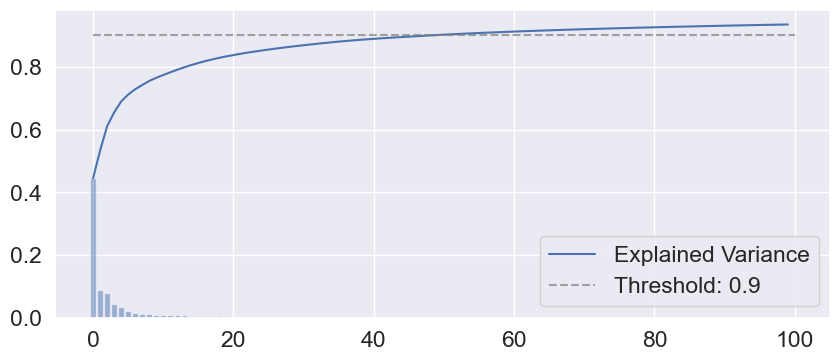

Number of components at threshold of 90%: 48


In [178]:
plt.figure(figsize=(10, 4))
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Explained Variance')
plt.bar(np.arange(100), pca.explained_variance_ratio_, alpha=0.5)
plt.hlines(0.9, 0, 100, ls='--', color='gray', alpha=0.7, label='Threshold: 0.9')

plt.legend()
plt.show()

pca_comp_ = (~(pca.explained_variance_ratio_.cumsum() > 0.9)).sum()
print(f"Number of components at threshold of 90%: {pca_comp_}")

In [179]:
# Specify new PCA features for use
Xtrain_pca  = Xtrain_pca[:, :48].reshape(-1, 1)
Xval_pca    = Xval_pca[:, :48].reshape(-1, 1)

## Linear Softmax classifier - Multinomial Logistic Regression

In [185]:
# Select which dataset version we want to run with

# Xtrain                  = Xtrain_orig
# Xval                    = Xval_orig
Xtrain                  = Xtrain_downsampled
Xval                    = Xval_orig
# Xtrain                  = Xtrain_pca.reshape(-1, 1, 1)
# Xval                    = Xval_pca.reshape(-1, 1, 1)


# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

ttrain  = ttrain_downsampled
N_train = Xtrain_downsampled.__len__()

In [186]:
design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# Create design matrices (for full data)
Phi_train       = design_matrix(Xtrain.reshape(N_train, -1))
Phi_val         = design_matrix(Xval.reshape(N_val, -1))
Phi_test        = design_matrix(Xtest.reshape(N_test, -1))

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval)

In [187]:
# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

print("--- LS ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_LS.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_LS, ord=2)}")

# Get ridge solution
lambd_ = 10.
theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_Ridge.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_Ridge, ord=2)}")

--- LS ESTIMATE OBTAINED ---
Number of parameters: (3073, 5)
Magnitude 3.4187691161701372

--- RIDGE ESTIMATE OBTAINED ---
Number of parameters: (3073, 5)
Magnitude 2.4470297757590527


In [188]:
def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    
    # define softmax
    softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

    # get latent function value
    y = Phi @ theta

    # get soft probabilty scores
    prob = softmax(y)

    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

# Get Ridge predictions 
ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

In [189]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_LS):.4f}")

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_Ridge):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.8553
Accuracy validation: 0.3751
Balanced accuracy train: 0.8553
Balanced accuracy validation: 0.3413

--- RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.8437
Accuracy validation: 0.3981
Balanced accuracy train: 0.8437
Balanced accuracy validation: 0.3612


##### Optimize lambda

In [190]:
from tqdm import tqdm

accuracy = {'train': {}, 'validation': {}}
balanced_accuracy = {'train': {}, 'validation': {}}

for lambd_ in tqdm(np.linspace(0, 21, 21), desc='Optimizing regularization strength...'):
    # Get ridge solution
    theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

    # Predict on test and validation data
    ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
    tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

    # Store performance
    accuracy['train'][lambd_]       = (ttrain_hat_Ridge == ttrain).mean()
    accuracy['validation'][lambd_]  = (tval_hat_Ridge == tval).mean()

    balanced_accuracy['train'][lambd_]       = balanced_accuracy_score(ttrain, ttrain_hat_Ridge)
    balanced_accuracy['validation'][lambd_]  = balanced_accuracy_score(tval, tval_hat_Ridge)

Optimizing regularization strength...: 100%|██████████| 21/21 [00:30<00:00,  1.46s/it]


Text(0.5, 1.0, 'Balanced accuracy')

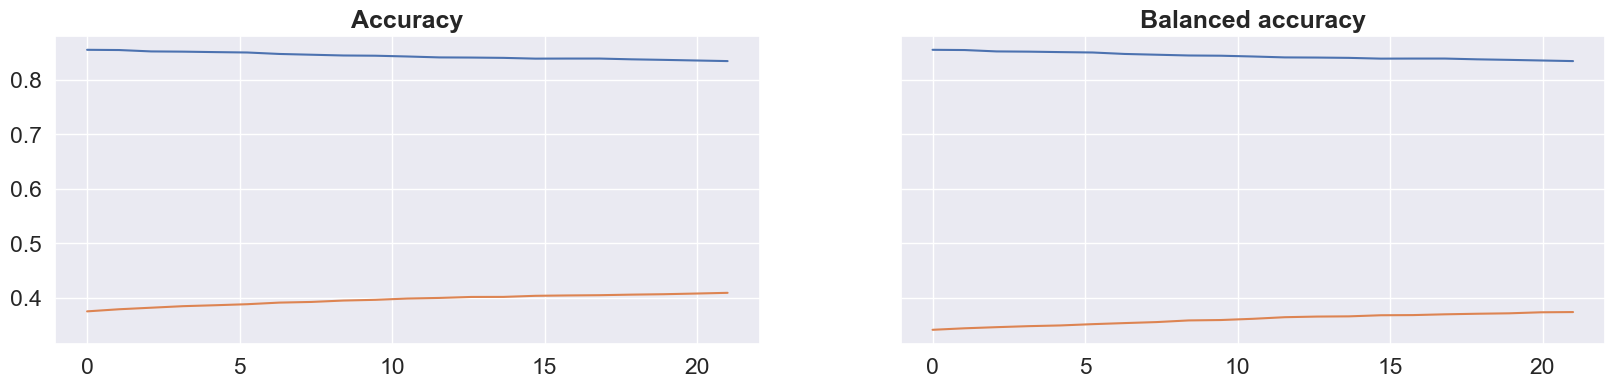

In [191]:
lamdba_grid, train_acc  = list(zip(*accuracy['train'].items()))
_, val_acc              = list(zip(*accuracy['validation'].items()))

_, train_bal_acc        = list(zip(*balanced_accuracy['train'].items()))
_, val_bal_acc          = list(zip(*balanced_accuracy['validation'].items()))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 4))

axs[0].plot(lamdba_grid, train_acc, color='C0', label='Training')
axs[0].plot(lamdba_grid, val_acc, color='C1', label='Validation')
axs[0].set_title('Accuracy', weight='bold')

axs[1].plot(lamdba_grid, train_bal_acc, color='C0', label='Training')
axs[1].plot(lamdba_grid, val_bal_acc, color='C1', label='Validation')
axs[1].set_title('Balanced accuracy', weight='bold')

### Evaluation 

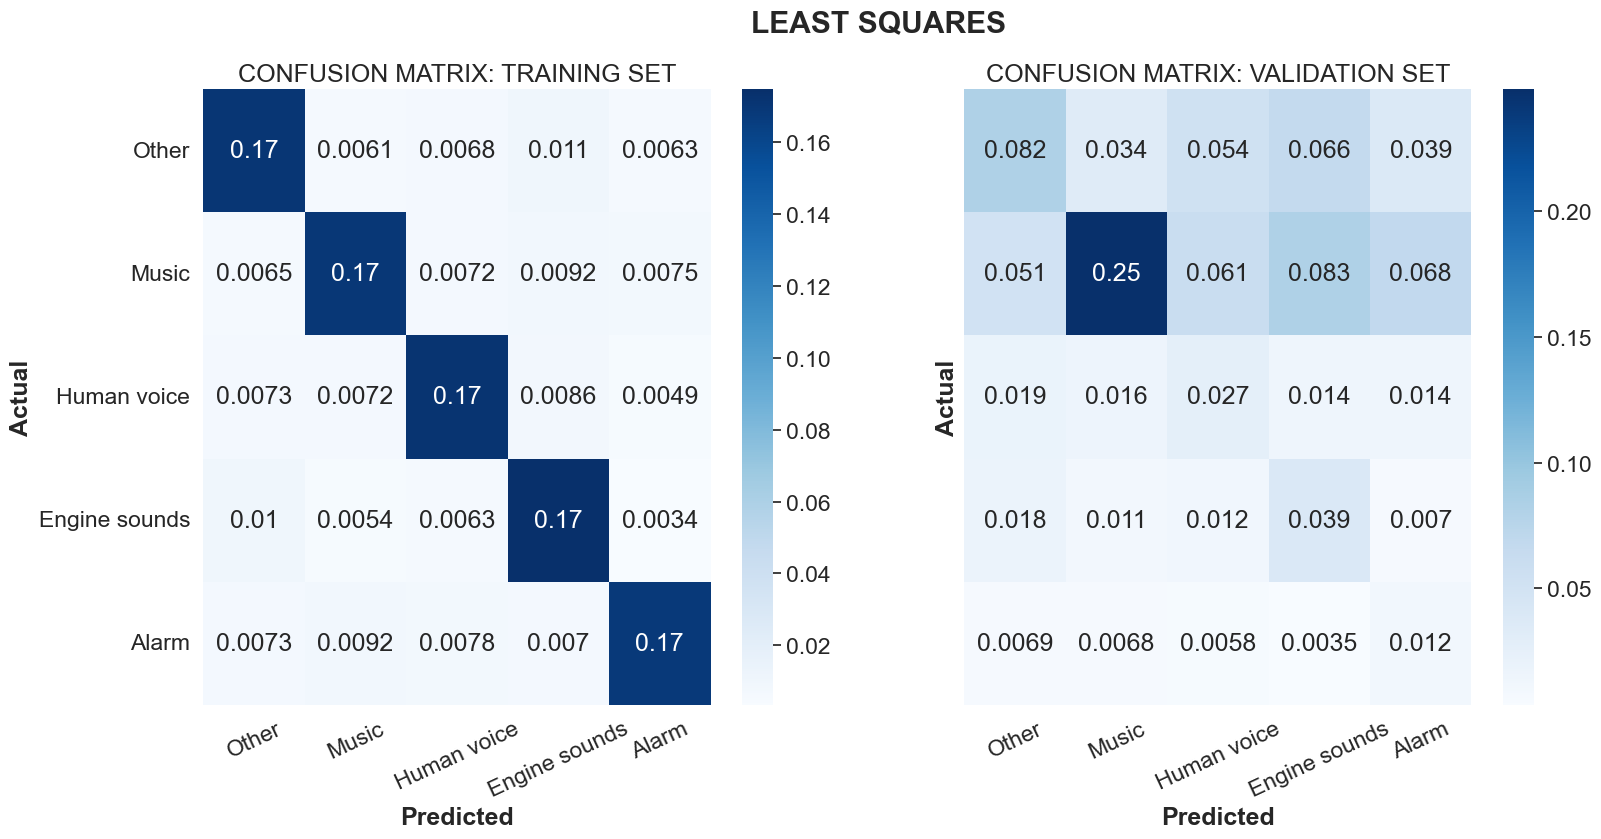

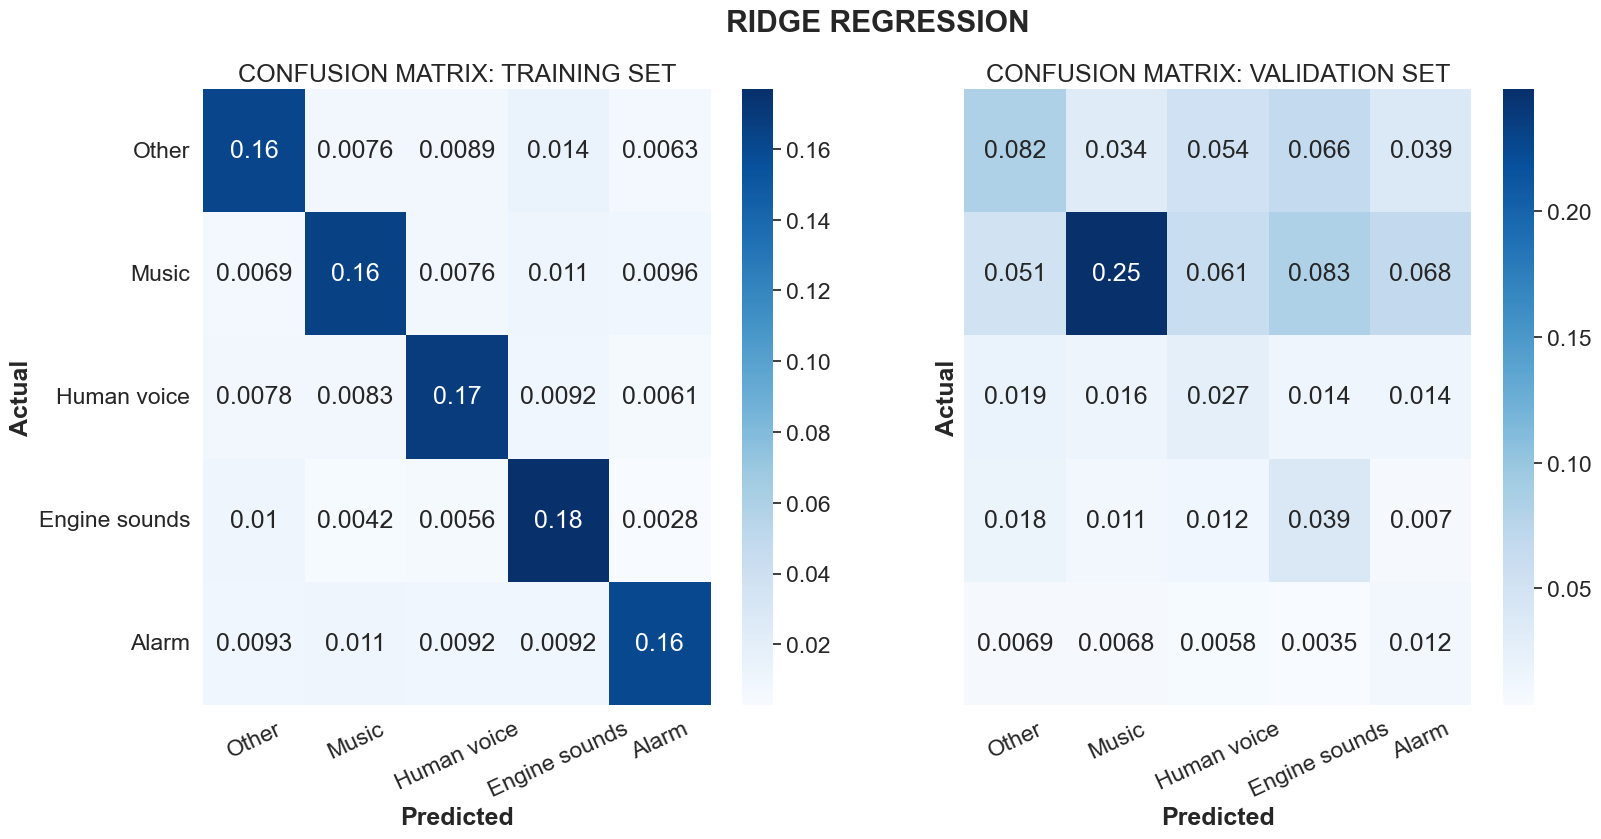

In [192]:
# Compute confusion matrices for least squares predictions
cm_train_LS = confusion_matrix(ttrain, ttrain_hat_LS, normalize='all')
cm_val_LS   = confusion_matrix(tval, tval_hat_LS, normalize='all')

# Compute confusion matrices for ridge predictions
cm_train_Ridge = confusion_matrix(ttrain, ttrain_hat_Ridge, normalize='all')
cm_val_Ridge   = confusion_matrix(tval, tval_hat_Ridge, normalize='all')


for reg_type in ['least squares', 'ridge regression']:
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 8))
    for i, (dtype, cm_) in enumerate({
        'training set': cm_train_LS if reg_type == 'least squares' else cm_train_Ridge, 
        'validation set': cm_val_LS if reg_type == 'least_squares' else cm_val_Ridge,
    }.items()):

        # Plot confusion matrix as heatmap
        sns.heatmap(cm_, annot=True, cmap='Blues', ax=axs[i])

        # Set ticks
        ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
        axs[i].set_xticks(ticks[0], ticks[1], rotation=25)
        axs[i].set_yticks(ticks[0], ticks[1], rotation=0)

        # Set labels and title
        axs[i].set_ylabel('Actual', weight='bold')
        axs[i].set_xlabel('Predicted', weight='bold')
        axs[i].set_title(f"Confusion matrix: {dtype}".upper())

    fig.suptitle(f'{reg_type}'.upper(), weight='bold')
    plt.show()

## Autoencoder

In [11]:
from collections import OrderedDict

import torch
import torch.nn as nn

In [44]:
import torch.nn as nn

def get_activation(activation: str):
    if activation == 'ReLU':
        return nn.ReLU()
    else:
        raise NotImplementedError

class ConvEncoderBlock(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, kernel_size: int, stride: int, padding: int = 0, activation='ReLU'):
        super(ConvEncoderBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            channels_in,
            channels_out,
            kernel_size,
            stride,
            padding,
        )
        self.bn1    = nn.BatchNorm2d(channels_out)
        self.act1   = get_activation(activation)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.pool1(out)
        return out

class TransposeConvDecoderBlock(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, kernel_size: int, stride: int, padding: int = 0, activation='ReLU'):
        super(TransposeConvDecoderBlock, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(
            channels_in,
            channels_out,
            kernel_size,
            stride,
            padding,
        )

        self.conv1 = nn.ConvTranspose2d(
            channels_in, 
            channels_out, 
            kernel_size=2, 
            stride=2
        )
        self.bn1    = nn.BatchNorm2d(channels_out)
        self.act1   = get_activation(activation) 
    
    def forward(self, z):
        out = self.conv1(z)
        out = self.bn1(out)
        out = self.act1(out)
        return out
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # setup parts
        self.encoder = nn.Sequential(OrderedDict([
            ('block1', ConvEncoderBlock(1, 256, kernel_size=3, stride=1, padding=1)),
            ('block2', ConvEncoderBlock(256, 128, kernel_size=3, stride=1, padding=1)),
            ('block3', ConvEncoderBlock(128, 64, kernel_size=3, stride=1, padding=1)),
            ('block4', ConvEncoderBlock(64, 32, kernel_size=3, stride=1, padding=1)),
        ]))
        self.encoder_fc = nn.Linear(in_features=32*6*2, out_features=32)

        self.decoder_fc = nn.Linear(in_features=32, out_features=32*6*2)
        self.decoder = nn.Sequential(OrderedDict([
            ('block1', TransposeConvDecoderBlock(32, 64, kernel_size=2, stride=2)),
            ('block2', TransposeConvDecoderBlock(64, 128, kernel_size=2, stride=2)),
            ('block3', TransposeConvDecoderBlock(128, 256, kernel_size=2, stride=2)),
            ('block4', TransposeConvDecoderBlock(256, 1, kernel_size=2, stride=2)),
        ]))

    def forward(self, x):
        # Encode input
        x_ = self.encoder(x)
        z = self.encoder_fc(x_.view(x.shape[0], -1))

        # Decode encoded input
        z_ = self.decoder_fc(z).view(x_.shape)
        x_recon = self.decoder(z_)
    
        return {'x_recon': x_recon, 'z': z}

In [57]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

AE = ConvAutoencoder().to(device)
print(AE)

ConvAutoencoder(
  (encoder): Sequential(
    (block1): ConvEncoderBlock(
      (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): ConvEncoderBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): ConvEncoderBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [58]:
print(f"Encoder parameters: \t\t{sum(param_.numel() for param_ in AE.encoder.parameters()) + sum(param_.numel() for param_ in AE.encoder_fc.parameters())}")
print(f"Decoder parameters: \t\t{sum(param_.numel() for param_ in AE.decoder.parameters())}")
print(f"Total number of parameters: \t{sum(param_.numel() for param_ in AE.parameters())}")

Encoder parameters: 		403136
Decoder parameters: 		174403
Total number of parameters: 	590211


In [66]:
# Create a dummy batch
x = torch.tensor(Xtrain[:32, :, :]).unsqueeze(1).to(device)
# Get reconstructions
output = AE(x)

print(output['x_recon'].shape)
print(output['z'].shape)

torch.Size([32, 1, 32, 96])
torch.Size([32, 32])


In [65]:
z1 = AE.encoder.block1(temp)
z2 = AE.encoder.block2(z1)
z3 = AE.encoder.block3(z2)
z4 = AE.encoder.block4(z3)
z5 = AE.encoder_fc(z4.view(temp.shape[0], -1))

print("Encoder shapes:")
print(z1.shape)
print(z2.shape)
print(z3.shape)
print(z4.shape)
print(z5.shape)

x1 = AE.decoder_fc(z5).view(z4.shape)
x2 = AE.decoder.block1(x1)
x3 = AE.decoder.block2(x2)
x4 = AE.decoder.block3(x3)
x5 = AE.decoder.block4(x4)

print("\nDecoder shapes:")
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

Encoder shapes:
torch.Size([32, 256, 16, 48])
torch.Size([32, 128, 8, 24])
torch.Size([32, 64, 4, 12])
torch.Size([32, 32, 2, 6])
torch.Size([32, 32])

Decoder shapes:
torch.Size([32, 32, 2, 6])
torch.Size([32, 64, 4, 12])
torch.Size([32, 128, 8, 24])
torch.Size([32, 256, 16, 48])
torch.Size([32, 1, 32, 96])
